In [17]:
import warnings, logging
warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.WARNING)

import os, pickle
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
def load_dataset(
                data_path = 'data/Loan/loan_category_data_set_01.csv',
                scalar_path = 'models/Loan/scalar.pkl'
                ):
    df = pd.read_csv(data_path)
    df = df.dropna()

    X = df.drop(columns=['Loan Category']).values
    Y = df['Loan Category'].values

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(
                                                    X, Y, 
                                                    test_size=0.15, 
                                                    random_state=42
                                                    )
    
    scalar = StandardScaler()
    scalar.fit(Xtrain)

    with open(scalar_path, 'wb') as f:
        pickle.dump(scalar, f)

    Xtrain = scalar.transform(Xtrain)
    Xtest = scalar.transform(Xtest)

    return Xtrain, Xtest, Ytrain, Ytest

In [19]:
Xtrain, Xtest, Ytrain, Ytest = load_dataset()

print('Xtrain shape:', Xtrain.shape)
print('Xtest shape:', Xtest.shape)
print('Ytrain shape:', Ytrain.shape)
print('Ytest shape:', Ytest.shape)

Xtrain shape: (850, 13)
Xtest shape: (150, 13)
Ytrain shape: (850,)
Ytest shape: (150,)


### Training

In [20]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(Xtrain, Ytrain)

with open('models/Loan/model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [21]:
Ptest = model.predict(Xtest)
Ptrain = model.predict(Xtrain)

### Evaluation

In [22]:
print("######################### Classification Report - Train #########################")
print(classification_report(
                            Ytrain, 
                            Ptrain
                            ))

print("########################## Classification Report - Test #########################")
print(classification_report(
                            Ytest, 
                            Ptest
                            ))

######################### Classification Report - Train #########################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       173
           1       1.00      1.00      1.00       166
           2       1.00      1.00      1.00       171
           3       1.00      1.00      1.00       174
           4       1.00      1.00      1.00       166

    accuracy                           1.00       850
   macro avg       1.00      1.00      1.00       850
weighted avg       1.00      1.00      1.00       850

########################## Classification Report - Test #########################
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       1.00      1.00      1.00        34
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        34

    accuracy         

########################## Confusion Matrix - Train #########################


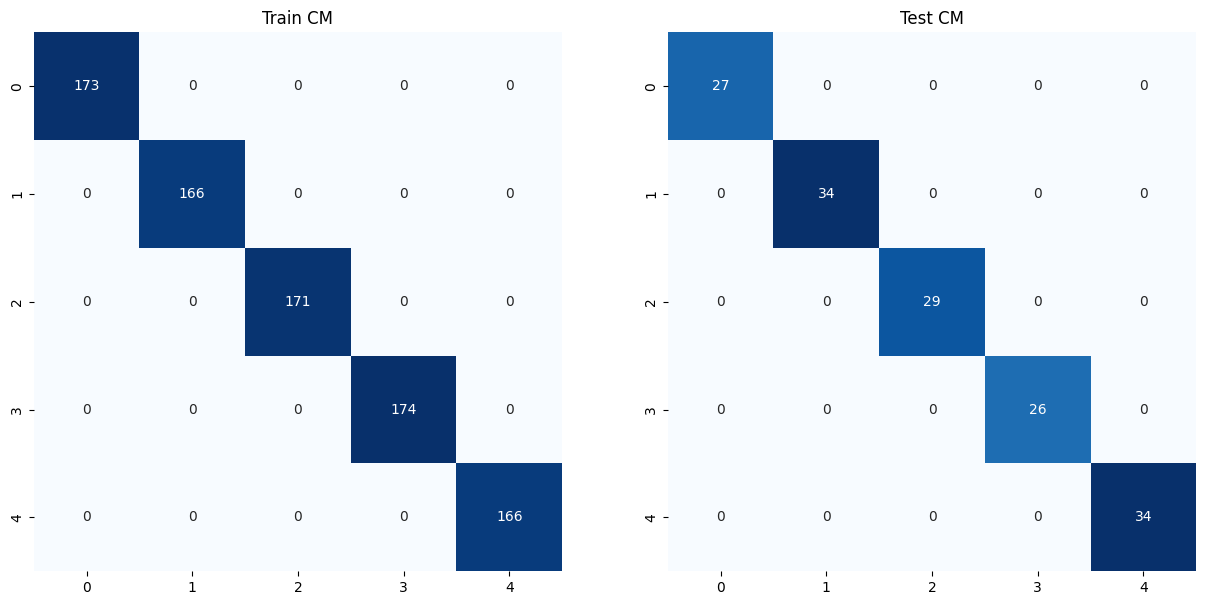

In [23]:
print("########################## Confusion Matrix - Train #########################")  

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
cm = confusion_matrix(Ytrain, Ptrain)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Train CM')

plt.subplot(1, 2, 2)
cm = confusion_matrix(Ytest, Ptest)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Test CM')

plt.show()

### Inference

In [24]:
import os, pickle
import numpy as np

In [25]:
with open('models/Loan/model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('models/Loan/scalar.pkl', 'rb') as f:
    scalar = pickle.load(f)

In [32]:
sample_json = {
                "Change Open Price (%)":-7.36,
                "Change Close Price (%)":-9.52,
                "Change Trade Volume (%)":-18.1,
                "Change Turnover (%)":-16.11,
                "Revenue":11.98,
                "Net Profit":-38.74,
                "Gross Profit":25.4,
                "Total Assets":4.67,
                "Total Liabilities":87.11,
                "Equity":30.21,
                "Export Change":24.7,
                "Import Change":17.70,
                "Sentiment Score":0.12
                }

In [33]:

import json

def make_response(prediction):
    with open('data/Loan/loan_features.json', 'r') as f:
        label2loan = json.load(f)

    loan = label2loan[str(prediction)]
    return loan 
    
def inference_loan(sample_json):
    sample = np.array([list(sample_json.values())])
    sample = scalar.transform(sample)
    prediction = int(model.predict(sample)[0])
    prediction = make_response(prediction)
    return prediction

In [34]:
inference_loan(sample_json)

{'loan_category': 'Higher Risk',
 'loan_features': {'loan_amount': 'Lower Loan Amounts: Smaller loan amounts due to higher risk.',
  'interest_rates': 'Higher Interest Rates: Increased rates to compensate for higher risk.',
  'repayment_periods': 'Shorter Repayment Periods: Quick recovery of funds to minimize exposure.',
  'collateral_requirement': 'Collateral Requirement: Collateral required to secure the loan.',
  'repayment_terms': 'Flexible Repayment Terms: Options to adjust payments based on financial situation.',
  'credit_monitoring': 'Credit Monitoring: Regular monitoring to ensure timely payments.',
  'financial_counseling': 'Financial Counseling: Access to advisory services to improve financial health.'}}